# Monte-carlo simulations

Xrmc and xmim-sim are used for simulation. The sample coordinate system is defined so that the beam travels along the Y-axis, the Z-axis points upwards and the X-axis is parallel with the synchrotron plane, pointing to the left when looking upstream. The detector reference frame (before transformation) is defined so that the Z-axis points upstream, the X-axis (detector image rows) points upwards and the Y-axis (detector image columns) points to the right when looking upstream.

Units are cm (distance), keV (energy) and seconds (time) unless noted otherwise.

In [26]:
from spectrocrunch.simulation.xrmc import XrmcWorldBuilder, loadxrmcresult, showxrmcresult
import numpy as np
import matplotlib.pyplot as plt

### Source

In [27]:
from spectrocrunch.sources import xray as xraysources
from spectrocrunch.materials import pymca
source = xraysources.factory("synchrotron")

pymcahandle = pymca.PymcaHandle(energy=7.5,
                                flux=1e9,
                                time=1,
                                linear=True,
                                escape=True,
                                continuum=True,
                                scatter=True)

def world_addsource(world, fullfield=False):
    distance = 42e2  # doesn't really matter
    # Beamsize at the sample
    if fullfield:
        beamsize = 100e-4  # cm
    else:
        beamsize = 1e-4  # cm
    world.definesource(flux=pymcahandle.flux.to('Hz').magnitude,
                       energy=pymcahandle.energy,
                       distance=distance,
                       beamsize=beamsize)

### Diode

Angles are defined with respect to the beam direction (angle=0 deg).

In [28]:
def world_adddiode(world, angle=0, multiplicity=10):
    forcedetect = False
    poissonnoise = False
    distance = 10  # cm
    activearea = 1  # cm^2
    world.adddiode(distance=distance, activearea=activearea,
                   orientation_inplane=angle, orientation_outplane=0,
                   poissonnoise=poissonnoise, ebinsize=None,
                   forcedetect=forcedetect, multiplicity=multiplicity,
                   time=pymcahandle.time.to('s').magnitude)

### XRF detector

Angles are defined with respect to the beam direction (angle=0 deg).

In [29]:
from spectrocrunch.materials import multilayer
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries

detector = xrfdetectors.factory("leia")
geometry = xrfgeometries.factory("sxm120",
                                 detector=detector,
                                 source=source)

def world_addsdd(world, angle_start=None, angle_end=None, convoluted=False, multiplicity=10):
    forcedetect = True
    poissonnoise = False
    distance = geometry.distance.to('cm').magnitude
    activearea = geometry.detector.activearea.to('cm**2').magnitude
    ebinsize = geometry.detector.mcagain  # keV
    if convoluted:
        detectormaterial = geometry.detector.material
        detectorthickness = geometry.detector.thickness

        window = geometry.detector.detectorfilters()
        material = [w['material'] for w in window]
        thickness = [w['thickness'] for w in window]
        windowmaterial = multilayer.Multilayer(material=material,
                                               thickness=thickness,
                                               name='sddwindow')
        windowthickness = sum(windowmaterial.thickness)
        windowmaterial = windowmaterial.mixlayers()
        if hasattr(windowmaterial, 'tocompound'):
            windowmaterial = windowmaterial.tocompound()

        world.addmaterial(detectormaterial)
        world.addmaterial(windowmaterial)
        response = {'material': detectormaterial.name,
                    'thickness': detectorthickness,
                    'windowmaterial': windowmaterial.name,
                    'windowthickness': windowthickness,
                    'noise': geometry.detector.mcanoise,
                    'fano': geometry.detector.mcafano}
        print(response)
    else:
        response = {}
    world.addxrfdetector(distance=distance, activearea=activearea,
                         orientation_inplane=angle_start, orientation_outplane=0,
                         ebinsize=ebinsize, poissonnoise=poissonnoise,
                         forcedetect=forcedetect, multiplicity=multiplicity,
                         response=response, time=pymcahandle.time.to('s').magnitude)
    if angle_start is None or angle_end is None:
        angle_start = angle_end = geometry.anglenormout
    if angle_start != angle_end:
        angle_nsteps = 30
        angle_step = float(angle_end-angle_start)/angle_nsteps
        #angle_step, angle_nsteps = angle_nsteps, angle_step
        world.detector.add_inplane_rotationloop(angle_step, angle_nsteps)

### Imaging camera

In [30]:
def world_addpco(world, multiplicity=10):
    forcedetect = True
    poissonnoise = False
    distance = 5  # cm
    shift = 0.000, 0.000  # cm
    angle = np.arctan2(shift, distance)*180/np.pi  # deg
    ebinsize = 5e-3  # keV
    n = 128
    projbeamsizetrans = 2 * (world.source.distance + distance) * np.tan(world.source.divergence)
    pixelsize = projbeamsizetrans/n  # beam fits exactly in detector (when angle=[0,0])
    world.addareadetector(distance=distance,
                          pixelsize=(pixelsize, pixelsize), dims=(n, n),
                          orientation_inplane=angle[0], orientation_outplane=angle[1],
                          ebinsize=ebinsize, poissonnoise=poissonnoise,
                          forcedetect=forcedetect, multiplicity=multiplicity,
                          time=pymcahandle.time.to('s').magnitude)

### Sample

In [31]:
from spectrocrunch.materials import compoundfromformula
from spectrocrunch.materials import compoundfromname
from spectrocrunch.materials import compoundfromlist
from spectrocrunch.materials import mixture
from spectrocrunch.materials import types

c1 = compoundfromname.compoundfromname("hematite")
c2 = compoundfromformula.CompoundFromFormula("PbSO4",density=6.29)
c3 = compoundfromlist.CompoundFromList(["Ca","C","O"],
                                       [1,1,3],
                                       types.fraction.mole,
                                       density=2.71,
                                       name="calcite")
toplayer = c1
substrate = mixture.Mixture([c2,c3],
                            [0.5,0.5],
                            types.fraction.mass,
                            name="Substrate")

sample = multilayer.Multilayer(material=[toplayer, substrate],
                               thickness=[10e-4, 20e-4],
                               geometry = geometry)

pymcahandle.sample = sample
print(sample)
print("")
print(geometry)

def world_addsample(world, fullfield=False):
    projbeamsizesample = 2 * (world.source.distance) * np.tan(world.source.divergence)
    assert world.source.beamsize == projbeamsizesample
    if fullfield:
        # Make sure the entire sample fits in the beam footprint
        samplesize = projbeamsizesample/2.
    else:
        # Make sure the sample is larger than the beam footprint
        samplesize = projbeamsizesample*10
    
    # All layers the same size and beam throught sample center
    nlayers = len(sample)
    dxs = [samplesize]*nlayers
    dys = [samplesize]*nlayers
    oxs = [0]*nlayers
    oys = [0]*nlayers
    
    # Make first layer smaller
    dxs[0] = 3*samplesize/4.
    dys[0] = samplesize/4.
    oxs[0] = (samplesize-dxs[0])/2.
    oys[0] = 0#-(samplesize-dys[0])/2.
    
    world.removesample()
    for layer, dx, dy, ox, oy in zip(sample, dxs, dys, oxs, oys):
        world.addmaterial(layer.material)
        world.addlayer(material=layer.material.name,
                       thickness=layer.thickness,
                       dhor=dx, dvert=dy, ohor=ox, overt=oy)

Multilayer (ordered top-bottom):
 Layer 0. 10.0 um (hematite)
 Layer 1. 20.0 um (50.00 wt% PbSO4 + 50.00 wt% calcite)

XraySource:
 intensity = 1.0 (W/m^2)
 dop = 1.0
 dolp = 1.0
 polangle = 0.0 (deg)
 handedness = none
XRF detector:
 Active area = 0.8 cm ** 2
 Ionization energy = 3.66856052632 eV
 Material = Si (0.045 cm)
Beam filters: None
Detector filters:
 ultralene = 0.0004064 cm
 Be = 0.0025 cm
MCA:
 zero = 0.0 eV
 gain = 5.0 eV
 noise = 50.0 eV (FWHM)
 fano = 0.19
Geometry:
 In = 62 deg
 Out = 58 deg (reflection)
 Azimuth = 0 deg
 Distance = 57.0 mm
 Solid angle = 4*pi*0.00194798955628 srad
 Detector position = 0 mm


### Run experiments

In [32]:
from spectrocrunch.io import localfs

experiments = ['xrf']

def run(world, interactions, simulate=True, plot=True, ylog=False):
    path = localfs.Path(world.main.path)
    if simulate:
        path.remove(recursive=True)
        world.finalize(interactions=interactions)
        if not world.simulate():
            #path.ls(recursive=True)
            raise RuntimeError('Simulation failed')
    else:
        world.finalize(interactions=interactions)
    #if plot:
    #    path.ls(recursive=True)
    data, info = loadxrmcresult(world.detector.outpath, world.detector.name)
    if plot:
        #info.pop('xenergy') # in case you want channels
        showxrmcresult(data, ylog=ylog, **info)
    return data, info

## Imaging

Visualize sample in transmission with a wide beam and an area detector. Test sample and detector rotation.

Positive rotation in the synchrotron plane:
- sample moves to the left when looking upstream
- detector moves to the left when looking upstream

Positive rotation out of the synchrotron plane:
- sample moves below the synchrotron plane
- detector moves below the synchrotron plane

This means rotations are defined as change-of-frame (inverse of object transformation).

In [33]:
if 'imaging' in experiments:
    path = r'/data/id21/tmp/xrmctest/imaging'
    world = XrmcWorldBuilder(path)
    world_addsource(world, fullfield=True)
    world_addsample(world, fullfield=True)
    world_addpco(world)
    world.quadrics.orientation_inplane = 0
    world.quadrics.orientation_outplane = 0
    world.quadrics.add_inplane_rotationloop(90, 1)
    world.quadrics.add_outplane_rotationloop(90, 1)
    data, info = run(world, (10, ), simulate=True)

## XANES
Transmission: diode behind the sample, fluorescence: diode at 110 degrees from the beam (in the synchrotron plane).

In [34]:
if 'xanes' in experiments:
    path = r'/data/id21/tmp/xrmctest/xanes'
    energy = np.linspace(7.05, 7.3, 30)
    world = XrmcWorldBuilder(path)
    world_addsource(world)
    world_addsample(world)
    world_adddiode(world)

    for order in range(2):
        # Do not force detection to get the 0-order (transmission).
        if order:
            label = 'fluorescence (order {})'.format(order)
            world.detector.forcedetect = True
            world.detector.orientation_inplane = 110
        else:
            label = 'transmission'
            world.detector.forcedetect = False
            world.detector.orientation_inplane = 0
        multiplicity = (1,) + (1000,)*order
        counts = np.zeros(energy.size)
        for i, en in enumerate(energy):
            world.spectrum.lines[0][0] = en
            data, info = run(world, multiplicity, simulate=True, plot=False)
            counts[i] = np.squeeze(data[order])
        if order==0:
            counts = -np.log(counts)
        counts -= counts.min()
        counts /= counts.max()
        tmp = plt.plot(energy, counts, label=label)
        plt.xlabel('Energy (keV)')
        plt.ylabel('Normalized XANES')
        plt.title('Exposure time = {} sec'.format(info['time']))
    tmp = plt.legend()

## XRF: scattering

Rotate fluorescence detector from 0 to 180 degrees (in plane of synchrotron).

In [35]:
if 'scattering' in experiments:
    path = r'/data/id21/tmp/xrmctest/xrf'
    world = XrmcWorldBuilder(path)
    energy = 7.5
    angle_start = 0
    angle_end = 180
    world_addsource(world, energy=energy)
    world_addsample(world)
    world_addsdd(world, multiplicity=10, angle_start=angle_start,
           angle_end=angle_end, convoluted=False)
    data, info = run(world, (1, 10000, ), simulate=True,
                     ylog=True, plot=False)

Plot evolution of elastic scattering peak

In [36]:
if 'scattering' in experiments:
    idx = np.argmin(np.abs(info['xenergy']-energy))
    y0, y1 = data[..., 0, 0, idx-5:idx+5].sum(axis=-1)
    x = np.linspace(angle_start, angle_end, y1.size)
    tmp = plt.plot(x, y1)
    plt.xlabel('Detector angle (deg)')
    plt.ylabel('Rayleigh counts')
    tmp = plt.title('Exposure time = {} sec'.format(info['time']))

## XRF: detection limits

{'noise': 0.05, 'windowthickness': 0.0029064, 'material': 'Si', 'fano': 0.19, 'thickness': 0.045, 'windowmaterial': 'sddwindow'}
Data shape: (2, 1, 1, 1, 1500)
Step 0
 Min counts/pixel (for each order): [0. 0.]
 Max counts/pixel (for each order): [   0.         8012.78838836]
 Total counts (for each order): [     0.         299884.23600111]


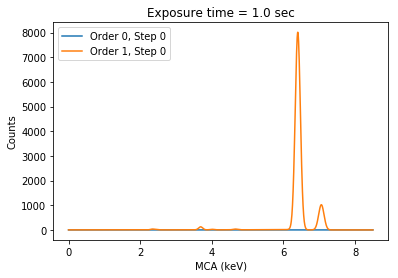

In [37]:
if 'xrf' in experiments:
    path = r'/data/id21/tmp/xrmctest/xrf'
    world = XrmcWorldBuilder(path)
    angle = 90
    world_addsource(world)
    world_addsample(world)
    world_addsdd(world, multiplicity=10, angle_start=angle,
           angle_end=angle, convoluted=True)
    data, info = run(world, (1, 10000, ), simulate=True,
                     ylog=False, plot=True)

In [38]:
if 'xrf' in experiments:
    counts = data[1, 0, 0, 0, :]